# Serendipyty

## Setup: matplotlib

In [42]:
%matplotlib inline
#%matplotlib notebook
#%matplotlib notebook

import matplotlib as mpl
import matplotlib.pyplot as plt
from matplotlib import gridspec
import matplotlib.animation as animation
from IPython.display import HTML

#mpl.rc('image', interpolation='none', origin='lower', cmap = 'gray')
mpl.rc('image', interpolation='none')
#plt.rcParams['figure.figsize'] = 10, 8
plt.rcParams['font.size'] = 14
plt.rcParams['figure.constrained_layout.use'] = True

# Get current size
fig_size = plt.rcParams["figure.figsize"]
 
# Prints: [8.0, 6.0]
print("Current size:", fig_size)

Current size: [6.0, 4.0]


## Setup: Import packages and set configuration parameters

In [43]:
# System
import sys
from timeit import default_timer as timer

# HPC
from joblib import Parallel, delayed
import multiprocessing

# Numerical
import numpy as np
import scipy.io

%load_ext autoreload
%autoreload 2
sys.dont_write_bytecode = True

# Serendipyty
from serendipyty.seismic.modelling import awe2d
from serendipyty.seismic.modelling.bcs import PmlBc

from serendipyty.seismic.utils.util import ricker
from serendipyty.seismic.utils.fd import stability
from serendipyty.seismic.utils.fd import dispersion
from serendipyty.seismic.utils.util import rectangle
from serendipyty.seismic.utils.util import oneface

from serendipyty.seismic.utils.dispersion import itdt3
from serendipyty.seismic.input.wavelets import RickerWavelet
from serendipyty.seismic.input.sources import PointSource
from serendipyty.seismic.model.models import AcousticModel
from serendipyty.seismic.hpc.hpc import BaseHpc

# Pandas
import pandas as pd

# Set numerical precision
DTYPE = np.float64

#if __name__ == '__main__':

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


## Parameters: geometry

In [44]:
## Domain properties
# Extent in # of cells
nx = 201
nz = 101
# Sampling in m
dx = DTYPE(5)
dz = DTYPE(5)

## Source
# Source locations in m
src_loc_m = np.array([600, 0, 250], dtype=DTYPE)
# Source locations in grid point
src_loc = np.array(src_loc_m/dx, dtype=np.uint)
# Type: 'q' for monopole source, 'fx' or 'fz' for dipole source
sourcetype = 'q'
# Central frequency
fc = DTYPE(30)

## Absorbing boundary conditions
# Size of absorbing boundary
npml = 30

bc = PmlBc(npml=npml, freesurface=True)

## Parameters: time

In [45]:
# Duration of simulation in s
tmax = 1.00
# Sampling in s
dt = DTYPE(0.001)
# Number of time samples
nt = int(tmax/dt)+1

## Create spatial and temporal axes

In [46]:
x = np.arange(nx)*dx
z = np.arange(nz)*dz
t = np.arange(nt)*dt

## Model: simple layered model

Acoustic


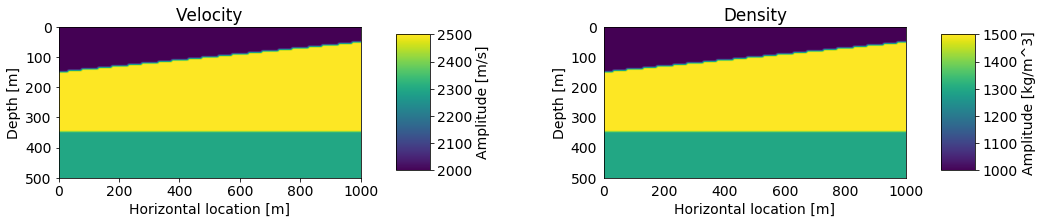

In [47]:
# Velocity and density of first layer
vp0 = 2000
rho0 = 1000

# Velocity and density ndarrays
vp = np.ones((nx, nz), dtype=DTYPE)*vp0
rho = np.ones((nx, nz), dtype=DTYPE)*rho0

# Create second layer
dip = 0.1
inta = (-dip)*x + 150.0
mask = np.zeros((nx,nz), dtype=np.bool)
for i in range(nx):
    mask[i, np.rint(inta[i]/dx).astype(int):] = True
vp[mask] = 2500
rho[mask] = 1500

# Create third layer
intb = 350
vp[:,np.rint(intb/dx).astype(int):] = 2300
rho[:,np.rint(intb/dx).astype(int):] = 1300

# Create model class
model = AcousticModel(dx, vp=vp, rho=rho)

# Plot material parameters
model.plot(extent=(x, z), colorbar=True, figsize=(15,3))

## Dispersion and stability analysis

In [48]:
# Compute dispersion criterion
dx_no_dispersion = dispersion(vp.min(), dx, fc, coeff=2.0)
print('To avoid (strong) spatial dispersion, the spatial sampling dx should be < {:.6}'.format(dx_no_dispersion))

# Compute the stability criterion
dt_stable = stability(vp.max(), dx, dt)
print('To avoid an unstable simulation, the temporal sampling dt should be < {:.6}'.format(dt_stable))

# Verify that the criteria are not violated
if dx < dx_no_dispersion and dt < dt_stable:
    print('Woot woot! The sampling values dx={:.6} and dt={:.6} are goood for this simulation!'.format(dx, dt))

To avoid (strong) spatial dispersion, the spatial sampling dx should be < 5.55556
To avoid an unstable simulation, the temporal sampling dt should be < 0.00141421
Woot woot! The sampling values dx=5.0 and dt=0.001 are goood for this simulation!


## Source

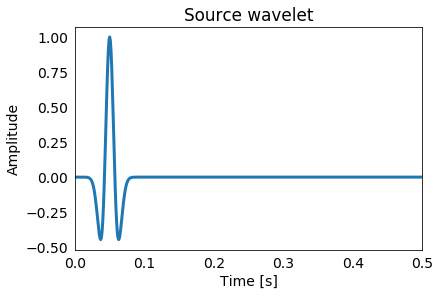

In [49]:
# Choose the wavelet
wav = RickerWavelet(t, fc=fc, delay=0.05)

# Choose the source type
src = PointSource(src_loc, wav, 'q')

# Plot the source wavelet
# fig = plt.plot(t, wav.wavelet)
line = src.plot(tmax=0.5)

## Receivers along recording and emitting surfaces

In [50]:
# Number of disjoint subdomains
# Currently, it is possible to use only one domain
# Extension to more domains is work in progress
nsub = 1

# Initialize arrays
semt_origins = np.ndarray((nsub, 4), dtype=np.uint)
srec_origins = np.ndarray((nsub, 4), dtype=np.uint)

# order: xemt zemt nxemt nzemt
semt_origins[0,:] = (0,  35,  nx,  nz-35)

# number of gridpoints between recording and emitting surfaces
ngpts = 2

# order: xrec zrec nxrec nzrec
srec_origins = semt_origins + np.array((0, ngpts, 0, 0), dtype=np.uint)

# Locations
# TO DO: this currently works fine because nsub is == 1
# When nsub > 1, I need to concatenate the locations along axis=0
#
for i in range(nsub):
    semt_locs = oneface(faces=(2,),
                        origin=(semt_origins[i][0], 0, semt_origins[i][1]),
                        number_of_cells=(semt_origins[i][2], 0, semt_origins[i][3]),
                        cell_size=(1,1,1)
                       )

for i in range(nsub):
    srec_locs = oneface(faces=(2,),
                        origin=(srec_origins[i][0], 0, srec_origins[i][1]),
                        number_of_cells=(srec_origins[i][2], 0, srec_origins[i][3]),
                        cell_size=(1,1,1)
                       )

In [51]:
df_srec_locs = pd.DataFrame(srec_locs)
df_srec_locs.columns = ['x', 'y', 'z', 'face']
df_srec_locs.head()

,x,y,z,face
0,0,0,37,2
1,1,0,37,2
2,2,0,37,2
3,3,0,37,2
4,4,0,37,2


## Define outputs

In [52]:
outparam = []
# Wavefield snapshots
outparam.append({'type': 'slice',
                 'timestep_increment': 10
                })
# Pressure wavefield along the semt_locs
outparam.append({'type': 'sub_volume_boundary',
                'attribute': 'p',
                'receiver_locations': semt_locs,
                'stagger_on_sub_volume': True,
                'timestep_increment': 10
                })
# Pressure wavefield along the srec_locs
outparam.append({'type': 'sub_volume_boundary',
                'attribute': 'vn',
                'receiver_locations': srec_locs,
                'stagger_on_sub_volume': True,
                'timestep_increment': 10
                })

## HPC parameters

In [53]:
ncores = multiprocessing.cpu_count()
print('This computer has {} cores'.format(ncores))

This computer has 16 cores


In [54]:
# HPC class
hpc = BaseHpc(omp_num_threads=12)

## Run simulation

In [55]:
outputs = awe2d.forward(model,src,outparam,bc,hpc)

The outputs are: {'slice': [0], 'sub_volume_boundary': [1, 2], 'shot_gather': []}
After: <class 'serendipyty.seismic.modelling.awe2d._memoryviewslice'>


In [56]:
print('The outputs are:')
for out in outputs.keys():
    print('- {}'.format(out))

if 'sub_volume_boundary' in outputs.keys():
    print('There are {} sub_volume_boundary outputs'.format(outputs['sub_volume_boundary'].shape[0]))

The outputs are:
- slice
- sub_volume_boundary
There are 2 sub_volume_boundary outputs


## Plot wave field snapshot

In [57]:
# Add model in the background
alpha = model.model[..., 0]
slicealpha = outputs['slice'][0, ...] + (alpha[None, ...] - alpha.mean())/1

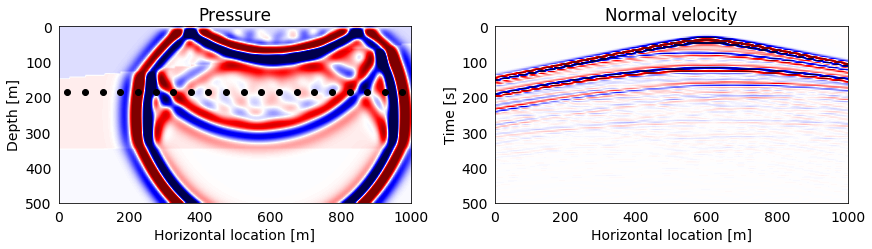

In [58]:
# Prepare figure

# Figure
figsize=(12, 6)
ndim = 2
fig, axs = plt.subplots(nrows=1, ncols=ndim, figsize=figsize, facecolor='w', edgecolor='k', squeeze=True)

# Plot options
clip=5e3
extent=[0, x[-1], z[-1], 0]
aspect='equal'
cmap='seismic'
interpolation='bilinear'
plotopts = {
    'vmin': -clip,
    'vmax': +clip,
    'aspect': aspect,
    'cmap': cmap,
    'interpolation': interpolation,
    'animated': True,
    'extent': extent
}

i = 20
im0 = axs[0].imshow(slicealpha[i, ...].T, **plotopts)
axs[0].scatter(srec_locs[5::10, 0]*dx, srec_locs[5::10, 2]*dz, color='k')
im1 = axs[1].imshow(outputs['sub_volume_boundary'][0, :, :], **plotopts)

axs[0].yaxis.set_label_text('Depth [m]')
axs[1].yaxis.set_label_text('Time [s]')

# ax0.set_aspect('equal')
axs[0].set_title('Pressure')
axs[1].set_title('Normal velocity')

for ax in axs:
    # Remove the ugly ticks
    ax.tick_params(
        which='both',      # both major and minor ticks are affected
        bottom=False,      # ticks along the bottom edge are off
        top=False,        # ticks along the top edge are off
        left=False,        # ticks along the top edge are off
        right=False        # ticks along the top edge are off
    )
    ax.xaxis.set_label_text('Horizontal location [m]')

## Create wavefield animation

In [59]:
blit = True
interval = 50
nframes = 100

def init():
    im0.set_array(slicealpha[0, ...].T)
    axs[0].scatter(srec_locs[5::10, 0]*dx, srec_locs[5::10, 2]*dz, color='k')
    im1.set_array(np.zeros_like(outputs['sub_volume_boundary'][0, ...]))
    return im0, im1,

def snap(i, snap, vb):
    im0.set_array(snap[i, ...].T)
    temp = im1.get_array()
    # print(temp.shape)
    temp[i, ...] = vb[i, ...]
    im1.set_array(temp)
    # Set title
    title0 = axs[0].title.set_text('Pressure (t:{0:.4})'.format(i*dt))
    return im0, im1,

anim = animation.FuncAnimation(fig, snap, init_func=init,
                              fargs=(slicealpha, outputs['sub_volume_boundary'][0, ...]), frames=nframes,
                              blit=blit, interval=interval, repeat=True)

In [60]:
HTML(anim.to_html5_video())
# HTML(anim.to_jshtml())

In [22]:
# Get current size
fig_size = plt.rcParams["figure.figsize"]
 
# Prints: [8.0, 6.0]
print("Current size:", fig_size)

Current size: [6.0, 4.0]
